In [3]:
import sys
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import shutil

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as utils_data
import torch.nn.functional as F


In [15]:
with open("input.txt") as inputf:
    text = inputf.read()
    
text = text.replace('<start>', '$')
text = text.replace('<end>', '%')
    
count_chars = Counter(text)
num_chars = len(count_chars)
    
#one hot encoding
char_to_int = {word:idx for idx,word in enumerate(count_chars.keys())}
int_to_char = {idx:word for idx,word in enumerate(count_chars.keys())}

In [4]:
def getDataLoader(random_seed, data_dir, seq_length, batchsize = 16, use_cuda = False, shuffle=True):
    
    with open(data_dir) as inputf:
        text = inputf.read()
    
    text = text.replace('<start>', '$')
    text = text.replace('<end>', '%')
    
    count_chars = Counter(text)
    num_chars = len(count_chars)
    
    #one hot encoding
    char_to_int = {word:idx for idx,word in enumerate(count_chars.keys())}
    int_to_char = {idx:word for idx,word in enumerate(count_chars.keys())}
    
    inputs = []
    labels = []
    temp_input = []
    temp_label = []
    
    for i, c in enumerate(text, 0):
        one_hot_encoding = torch.zeros((1, num_chars))
        one_hot_encoding[0, char_to_int[c]] = 1
        temp_input.append(one_hot_encoding)
        temp_label.append(char_to_int[c])
        if i % seq_length == seq_length - 1:
            inputs.append(torch.cat(temp_input, 0))
            labels.append(torch.LongTensor(temp_label))
            temp_input = []
            temp_label = []
    
    inputs, labels = torch.stack(inputs, 0), torch.stack(labels, 0)
    
    dataset = utils_data.TensorDataset(inputs, labels)
    dataset_size = len(dataset)
    
    indices = np.arange(dataset_size)
    
    split = int(dataset_size * 0.2)
    
    train_inds = indices[: -split]
    valid_inds = indices[-split:]
    
    if shuffle:
        trainsampler = torch.utils.data.sampler.SubsetRandomSampler(train_inds)
        validsampler = torch.utils.data.sampler.SubsetRandomSampler(valid_inds)
    else:
        trainsampler = torch.utils.data.sampler.SequentialSampler(train_inds)
        validsampler = torch.utils.data.sampler.SequentialSampler(valid_inds)
    
    if use_cuda:
        pin_memory = True
    else:
        pin_memory = False

    training_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, 
                                                      num_workers = 4, sampler = trainsampler, 
                                                      pin_memory = pin_memory)
    valid_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize,
                                                  num_workers = 4, sampler = validsampler, 
                                                  pin_memory = pin_memory)

    dataloaders = [training_dataloader, valid_dataloader]
    
    print ('data loaded.')
    
    return dataloaders, num_chars

In [5]:
def training(model, criterion, optimizer, epochs, dataloaders, step_size = None, 
             gamma = None, early_stop = False, use_cuda = False, checkpoint_ind = 1, 
             model_dir = None, best_model = False, shuffle = True):
    
    '''
    function that trains and save/load the model
    args:
            criterion: loss function
            epochs: # of epochs to iterate
            dataloaders: list of torch.utils.data.DataLoader, the first element must be 
                         dataloader for training set
            step_size: if None, then no learning rate decay is applied; 
                       if an integer, learning rate decays for every step_size epochs;
                       if a list, learning rate decays at specific epochs given in list
            gamma: decay ratio for learning rate at each time of decay
            early_stop: if True, training will stop if validation loss rises consistently 
                        for 6 epochs (the second element in dataloaders will be regarded 
                        as the dataloader for validation set as default)
            use_cuda: if True, model will be trained with .cuda()
            model_dir: if not None, it will try to load pre-saved model in 'model_dir' and 
                       resume the training (including optimizer and learning rate scheduler)
            best_model: if True, it will try to load pre-saved best model in 'model_dir' 
                        and resume the training (including optimizer and learning rate 
                        scheduler)
    
    return:
            statlists: a list containing statistics during training
                       len(statlists) is equal to len(dataloaders)
    '''
    
    print ('start training...')
    
    from_scratch = True
    
    if model_dir is not None:
        # load model saved early and resume training
        if best_model:
            model_dir = model_dir + '/' + 'best_' + model.__class__.__name__ + '_ckpt' + str(checkpoint_ind) + '.pth.tar'
        else:
            model_dir = model_dir + '/' + model.__class__.__name__ + '_ckpt' + str(checkpoint_ind) + '.pth.tar'
        if os.path.isfile(model_dir):
            print ("loading checkpoint '{}'".format(model_dir))
            from_scratch = False
            checkpoint = torch.load(model_dir)
            start_epoch = checkpoint['epoch']
            statlists = checkpoint['stats']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print ("loaded checkpoint '{}' (epoch {})".format(model_dir, checkpoint['epoch']))
            if isinstance(step_size, int):
                scheduler = lr_scheduler.StepLR(optimizer = optimizer, step_size = step_size, 
                                                gamma = gamma, last_epoch = (start_epoch - 1))
            elif isinstance(step_size, list):
                scheduler = lr_scheduler.MultiStepLR(optimizer = optimizer, milestones = step_size, 
                                                gamma = gamma, last_epoch = (start_epoch - 1))
            min_valid_loss = np.min(statlists[1])
        else:
            print ("no checkpoint found at '{}'.".format(model_dir), 'training from scratch.')
    
    # only if the model_dir is given, and such a model does exist, we will not training from scratch
    if from_scratch:
        # training from scratch
        start_epoch = 1
        statlists = [[] for _ in np.arange(len(dataloaders))]
        if isinstance(step_size, int):
            scheduler = lr_scheduler.StepLR(optimizer = optimizer, step_size = step_size, 
                                            gamma = gamma)
        elif isinstance(step_size, list):
            scheduler = lr_scheduler.MultiStepLR(optimizer = optimizer, milestones = step_size, 
                                            gamma = gamma)
        min_valid_loss = 10e6
    
    
    stop = 0
    filename = model.__class__.__name__ + '_ckpt' + str(checkpoint_ind)
    
    # training iteration
    for epoch in np.arange(start_epoch, epochs + 1):
    
        if not use_cuda:
            avg_loss = 0.0
            
        if step_size is not None:
            scheduler.step()

        model.train()
        
        if not shuffle:
                init_hidden = model.init_hidden()
                if 'LSTM' in model.__class__.__name__:
                    model.hidden = (init_hidden[0].cuda(), init_hidden[1].cuda())
                elif 'GRU' in model.__class__.__name__:
                    model.hidden = init_hidden.cuda()

        for i, data in enumerate(dataloaders[0], 0):
            loss = 0
            inputs, labels = data
            if inputs.size(0) < model.batchsize:
                break
            inputs_len = len(inputs[0])
            inputs, labels = inputs.permute(1, 0, 2)[: inputs_len - 1, :, :], labels[:, 1:]
            # inputs: <class 'torch.FloatTensor'> torch.Size([sequence length, batchsize, 95]) 
            # labels: <class 'torch.LongTensor'> torch.Size([batchsize, ])  
            if use_cuda:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
                if shuffle:
                    init_hidden = model.init_hidden()
                    if 'LSTM' in model.__class__.__name__:
                        model.hidden = (init_hidden[0].cuda(), init_hidden[1].cuda())
                    elif 'GRU' in model.__class__.__name__:
                        model.hidden = init_hidden.cuda()
            else:
                inputs = Variable(inputs)
                labels = Variable(labels)
                if shuffle:
                    model.hidden = model.init_hidden()
            optimizer.zero_grad()
            outputs = model(inputs)
#             sys.exit(0)
            for i in range(outputs.size(1)):
                loss += criterion(outputs[:, i, :], labels[i, :])
            loss = loss / model.batchsize
            
            if shuffle:
                loss.backward()
            else:
                loss.backward(retain_graph=True)
            optimizer.step()

            if not use_cuda:
                avg_loss += loss.data[0]

                if i % 200 == 199:
                    print('[%d, %5d] loss: %.3f' %(epoch, i + 1, avg_loss / 200))
                    avg_loss = 0.0

        model.eval()
        
        # evaluate model after each epoch
        if use_cuda:
            if not shuffle:
                init_hidden = model.init_hidden()
                if 'LSTM' in model.__class__.__name__:
                    model.hidden = (init_hidden[0].cuda(), init_hidden[1].cuda())
                elif 'GRU' in model.__class__.__name__:
                        model.hidden = init_hidden.cuda()
            for loader, statlist in zip(dataloaders, statlists):
                totalloss = 0.0
                batchs = 0
                for data in loader:
                    batchloss = 0
                    inputs, labels = data
                    if inputs.size(0) < model.batchsize:
                        break
                    inputs_len = len(inputs[0])
                    inputs, labels = inputs.permute(1, 0, 2)[: inputs_len - 1, :, :], labels[:, 1:]
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    if shuffle:
                        init_hidden = model.init_hidden()
                        if 'LSTM' in model.__class__.__name__:
                            model.hidden = (init_hidden[0].cuda(), init_hidden[1].cuda())
                        elif 'GRU' in model.__class__.__name__:
                            model.hidden = init_hidden.cuda()
                    outputs = model(inputs)
                    for i in range(outputs.size(1)):
                        batchloss += criterion(outputs[:, i, :], labels[i, :]).data[0]
                    totalloss += batchloss / model.batchsize
                    batchs += 1

                statlist.append(totalloss / batchs)
            
            print('epoch: %d       loss:' %epoch, end = '', flush = True)
            for statlist in statlists:
                print ('%.3f         ' %statlist[-1], end = '', flush = True)
            print ('')
            
            if min_valid_loss > statlists[1][-1]:
                is_best = True
                min_valid_loss = statlists[1][-1]
            else:
                is_best = False
            
            # model will be saved for each 10 epochs, or if the current model obtains 
            # best performance so far.
            if is_best or (epoch % 10 == 0):
                save_checkpoint({'epoch': epoch + 1,
                                'state_dict': model.state_dict(),
                                'stats': statlists,
                                'optimizer': optimizer.state_dict()
                                }, is_best, filename)
            
        if early_stop and epoch >= 2:
            if statlists[1][-1] >= statlists[1][-2]:
                stop += 1
            else:
                stop = 0
            
            if stop >= 6:
                print ('stop training due to rising validloss.')
                save_checkpoint({'epoch': epoch + 1,
                                'state_dict': model.state_dict(),
                                'stats': statlists,
                                'optimizer': optimizer.state_dict()
                                }, False, filename)
                break

    print ('training finished.')
    
    return statlists
    
    
# the save/load model code can be found at 
# https://github.com/pytorch/examples/blob/master/imagenet/main.py#L267
def save_checkpoint(state, is_best, filename = 'checkpoint'):
    path_name = './model/' + filename + '.pth.tar'
    torch.save(state, path_name)
    if is_best:
        best_path = './model/' + 'best_' + filename + '.pth.tar'
        shutil.copyfile(path_name, best_path)
    print ('model saved.')

In [6]:
def plot_loss(loss):
    '''
    function for plotting loss
    args:
            loss: a list containing loss evaluated on each set of data after each epoch
                  during training. 
                  loss[0] for training loss; loss[1] for validation loss; 
                  loss[2] for test loss.
                  
    '''
    epoch_range = range(1, len(loss[0]) + 1)

    plot1 = plt.plot(epoch_range, loss[0], 'r', linewidth = 1.4, label = 'training_loss')
    plot2 = plt.plot(epoch_range, loss[1], 'g', linewidth = 1.4, label = 'validation_loss')
#   plot3 = plt.plot(epoch_range, loss[2], 'b', linewidth = 1.4, label = 'test_loss')

    plt.title('Loss Plot')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend(loc = 'best')
    plt.show()
    

In [7]:
use_cuda = torch.cuda.is_available()

print ('use_cuda: ', use_cuda)

data_dir = './input.txt'

batchsize = 1

dataloaders, num_chars = getDataLoader(random_seed = 0, data_dir = data_dir, seq_length = 25, 
                            batchsize = batchsize, use_cuda = use_cuda, shuffle=False)

use_cuda:  True
data loaded.


In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, batchsize):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.hidden_layers = hidden_layers
        self.batchsize = batchsize
        self.lstm = nn.LSTM(input_size, hidden_size, hidden_layers)
        self.hidden = self.init_hidden()      
        self.linear = nn.Linear(hidden_size, self.output_size)
    
    def init_hidden(self):
        return (Variable(torch.zeros(self.hidden_layers, self.batchsize, self.hidden_size)),
                Variable(torch.zeros(self.hidden_layers, self.batchsize, self.hidden_size)))
    
    def forward(self, x):       
        lstm_out, self.hidden = self.lstm(x.view(len(x), self.batchsize, -1), self.hidden)   
#         print (lstm_out.size(), self.hidden[0].size())
#         print ('lstm_out:\n', lstm_out[-1])
#         print ('hidden states:\n', self.hidden[0])
#         if lstm_out[-1] == self.hidden[0][0]:
#             print ('equal')
        lstm_out = self.linear(lstm_out)
        return lstm_out

In [9]:
#dtype = torch.FloatTensor

lstm = LSTM(num_chars, 2, 256, batchsize)

if use_cuda:
    lstm = lstm.cuda()
    loss_function = nn.CrossEntropyLoss().cuda()
else:
    loss_function = nn.CrossEntropyLoss()
    
learning_rate = 0.01

optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate, momentum=0.9)

num_epoch = 20

statlists = training(model = lstm, criterion = loss_function, optimizer = optimizer, 
                     epochs = num_epoch, dataloaders = dataloaders, step_size = 20, 
                     gamma = 0.1, use_cuda = use_cuda, model_dir = None)
# def training(model, criterion, optimizer, epochs, dataloaders, step_size = None, 
#              gamma = None, early_stop = False, use_cuda = False, model_dir = None, 
#              best_model = False):

start training...
epoch: 1       loss:3.138         3.583         
model saved.
epoch: 2       loss:2.761         3.196         
model saved.
epoch: 3       loss:2.557         2.965         
model saved.
epoch: 4       loss:2.396         2.781         
model saved.
epoch: 5       loss:2.300         2.678         
model saved.
epoch: 6       loss:2.240         2.627         
model saved.
epoch: 7       loss:2.200         2.591         
model saved.
epoch: 8       loss:2.168         2.565         
model saved.
epoch: 9       loss:2.141         2.546         
model saved.
epoch: 10       loss:2.116         2.533         
model saved.
epoch: 11       loss:2.117         2.544         
epoch: 12       loss:2.105         2.537         


Process Process-148:
Process Process-146:
Process Process-145:
Process Process-147:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", li

KeyboardInterrupt: 

In [34]:
# lstm = LSTM(num_chars, 1, 64, batchsize)

# if use_cuda:
#     lstm = lstm.cuda()
#     loss_function = nn.CrossEntropyLoss().cuda()
# else:
#     loss_function = nn.CrossEntropyLoss()
    
# learning_rate = 0.01

# optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate, momentum=0.9)

# num_epoch = 100

# statlists = training(model = lstm, criterion = loss_function, optimizer = optimizer, 
#                      epochs = num_epoch, dataloaders = dataloaders, step_size = 20, 
#                      gamma = 0.1, use_cuda = use_cuda, checkpoint_ind = 9, 
#                      model_dir = None)
'''
    outputs of lstm are just stacking of hidden states h at each time step t.
'''

start training...
torch.Size([24, 4, 64]) torch.Size([1, 4, 64])
lstm_out:
 Variable containing:

Columns 0 to 9 
 0.0142 -0.0750 -0.0304  0.0431  0.0240 -0.0460  0.0270  0.1068 -0.1055  0.0773
 0.0456 -0.0503  0.0019  0.0250  0.0045 -0.0453  0.0056  0.1224 -0.1513  0.0828
 0.0776 -0.0970  0.0227  0.0703 -0.0636 -0.0807 -0.0203  0.1375 -0.0802  0.0972
 0.0497 -0.0596 -0.0446  0.0331 -0.0114 -0.0410 -0.0037  0.1251 -0.1528  0.0333

Columns 10 to 19 
 0.0922 -0.0371  0.0073  0.0150 -0.0852 -0.0875 -0.1619 -0.0351 -0.0509  0.0204
 0.1214 -0.0429  0.0198 -0.0012 -0.1098 -0.0512 -0.1294 -0.0829 -0.1081  0.0084
 0.0774 -0.0195  0.0766  0.0481 -0.1127 -0.0386 -0.1338 -0.0773 -0.1144 -0.0316
 0.0508 -0.0185 -0.0077  0.0616 -0.0317 -0.0633 -0.1208 -0.0518 -0.1120 -0.0308

Columns 20 to 29 
-0.0171  0.0549  0.0336  0.0008 -0.1027  0.0456  0.0996 -0.0111  0.0471  0.0717
 0.0130  0.0684  0.0454 -0.0047 -0.0871  0.0730  0.0948  0.0287 -0.0012  0.1026
 0.0201  0.0013  0.0669  0.0178 -0.0770  0.0931 

RuntimeError: bool value of Variable objects containing non-empty torch.cuda.ByteTensor is ambiguous

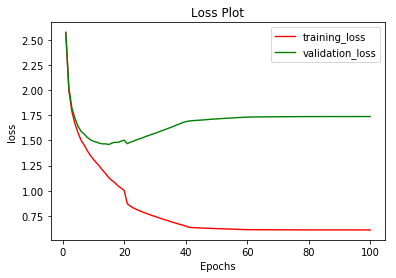

min validation loss:  1.45943165395


In [34]:
plot_loss(statlists)
print ('min validation loss: ', np.min(statlists[1]))

In [15]:
lstm = LSTM(num_chars, 1, 128, num_chars)

if use_cuda:
    lstm = lstm.cuda()
    loss_function = nn.CrossEntropyLoss().cuda()
else:
    loss_function = nn.CrossEntropyLoss()
    
learning_rate = 0.01

optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate, momentum=0.9)

num_epoch = 50

statlists = training(model = lstm, criterion = loss_function, optimizer = optimizer, 
                     epochs = num_epoch, dataloaders = dataloaders, step_size = 10, 
                     gamma = 0.1, use_cuda = use_cuda, checkpoint_ind = 2, 
                     model_dir = None)

start training...
epoch: 1       loss:2.261         2.274         
model saved.
epoch: 2       loss:1.939         1.968         
model saved.
epoch: 3       loss:1.817         1.852         
model saved.
epoch: 4       loss:1.720         1.768         
model saved.
epoch: 5       loss:1.656         1.712         
model saved.
epoch: 6       loss:1.613         1.675         
model saved.
epoch: 7       loss:1.576         1.648         
model saved.
epoch: 8       loss:1.554         1.633         
model saved.
epoch: 9       loss:1.519         1.609         
model saved.
epoch: 10       loss:1.498         1.590         
model saved.
epoch: 11       loss:1.446         1.558         
model saved.
epoch: 12       loss:1.439         1.555         
model saved.
epoch: 13       loss:1.434         1.555         
model saved.
epoch: 14       loss:1.430         1.555         
epoch: 15       loss:1.426         1.553         
model saved.
epoch: 16       loss:1.422         1.552         
model sav

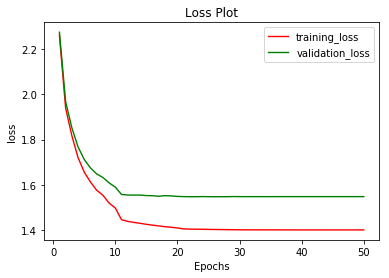

min validation loss:  1.54750869576


In [16]:
plot_loss(statlists)
print ('min validation loss: ', np.min(statlists[1]))

In [118]:
class LSTM_bi(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, batchsize):
        super(LSTM_bi, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.hidden_layers = hidden_layers
        self.batchsize = batchsize
        self.lstm = nn.LSTM(input_size, hidden_size, hidden_layers, bidirectional = True)
        self.hidden = self.init_hidden()      
        self.linear = nn.Linear(2 * hidden_size, self.output_size)
    
    def init_hidden(self):
        return (Variable(torch.zeros(2 * self.hidden_layers, self.batchsize, self.hidden_size)),
                Variable(torch.zeros(2 * self.hidden_layers, self.batchsize, self.hidden_size)))
    
    def forward(self, x):       
        lstm_out, self.hidden = self.lstm(x.view(len(x), self.batchsize, -1), self.hidden) 
        lstm_out = self.linear(lstm_out)
        return lstm_out

In [ ]:
lstm = LSTM_bi(num_chars, 1, 128, batchsize)

if use_cuda:
    lstm = lstm.cuda()
    loss_function = nn.CrossEntropyLoss().cuda()
else:
    loss_function = nn.CrossEntropyLoss()
    
learning_rate = 0.01

optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate, momentum=0.9)

num_epoch = 300

statlists = training(model = lstm, criterion = loss_function, optimizer = optimizer, 
                     epochs = num_epoch, dataloaders = dataloaders, step_size = 100, 
                     gamma = 0.1, use_cuda = use_cuda, checkpoint_ind = 9, 
                     model_dir = None)

start training...
epoch: 1       loss:0.904         0.898         
model saved.
epoch: 2       loss:0.354         0.352         
model saved.
epoch: 3       loss:0.228         0.230         
model saved.
epoch: 4       loss:0.179         0.182         
model saved.
epoch: 5       loss:0.156         0.159         
model saved.
epoch: 6       loss:0.145         0.149         
model saved.
epoch: 7       loss:0.135         0.138         
model saved.
epoch: 8       loss:0.130         0.134         
model saved.
epoch: 9       loss:0.125         0.129         
model saved.
epoch: 10       loss:0.121         0.125         
model saved.
epoch: 11       loss:0.119         0.124         
model saved.
epoch: 12       loss:0.115         0.119         
model saved.
epoch: 13       loss:0.114         0.118         
model saved.
epoch: 14       loss:0.112         0.116         
model saved.
epoch: 15       loss:0.110         0.114         
model saved.
epoch: 16       loss:0.109         0.114      

In [40]:
class LSTM_ss(nn.Module):
    def __init__(self, input_size, hidden_size, batchsize, method = 'linear'):
        super(LSTM_ss, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.batchsize = batchsize
        self.sampling_method = method
        if self.sampling_method == 'linear':
            self.c = 1 / 150000
        elif self.sampling_method == 'exponential':
            self.c = 0.99995
        elif self.sampling_method == 'inverse sigmoid':
            self.c = 25000
        self.i = 0
        self.p = 1
        self.cell = nn.LSTMCell(input_size, hidden_size)
        self.hidden = self.init_hidden()      
        self.linear = nn.Linear(hidden_size, self.output_size)
    
    def init_hidden(self):
        return (Variable(torch.zeros(self.batchsize, self.hidden_size)),
                Variable(torch.zeros(self.batchsize, self.hidden_size)))
    
    def scheduled_sampling():
        if self.sampling_method == 'linear':
            self.p = torch.max(0.1, 1 - self.c * self.i)
        elif self.sampling_method == 'exponential':
            self.p = self.p * self.c
        elif self.sampling_method == 'inverse sigmoid':
            self.p = self.c / (self.c + np.exp(self.i / self.c))           
        self.i += 1
    
    def forward(self, x):
        lstm_out = []
        self.scheduled_sampling()
        decision = np.random.binomial(n = 1, p = self.p, size = x.size(0))
        print ('decision:\n', decision)
        for i in range(x.size(0)):
            self.hidden = self.cell(x[i], self.hidden)  
            lstm_out.append(self.linear(self.hidden[0]))
        lstm_out = torch.stack(lstm_out, 0)
        return lstm_out

In [39]:
lstm = LSTM_ss(num_chars, 128, batchsize)

if use_cuda:
    lstm = lstm.cuda()
    loss_function = nn.CrossEntropyLoss().cuda()
else:
    loss_function = nn.CrossEntropyLoss()
    
learning_rate = 0.01

optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate, momentum=0.9)

num_epoch = 300

statlists = training(model = lstm, criterion = loss_function, optimizer = optimizer, 
                     epochs = num_epoch, dataloaders = dataloaders, step_size = 100, 
                     gamma = 0.1, use_cuda = use_cuda, checkpoint_ind = 1, 
                     model_dir = None)

start training...
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
to

Process Process-45:
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-46:
Process Process-47:
Process Process-48:
Traceback (most recent call last):
Traceback (most recent call last):


torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])


Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _

In [10]:
def simulate(ran, dist):
    r = np.random.random()
    sum = 0
    for i in range(ran):
        sum += dist[i]
        if r < sum:
            return i

In [11]:
def wrap(s):
    starter = []
    for c in s:
        index = char_to_int[c]
        one_hot_encoding = torch.zeros(1,num_chars)
        one_hot_encoding[0,index] = 1
        starter.append(one_hot_encoding)
    starter = Variable(torch.stack(starter).type(torch.FloatTensor)).cuda()
    return starter

In [12]:
def compose(model, starter_str, temp):
    starter = wrap(starter_str)
    init_hidden = model.init_hidden()
    model.hidden = (init_hidden[0].cuda(), init_hidden[1].cuda())
    output = model(starter)[-1].view(-1,num_chars)
    softmax = torch.nn.Softmax()
    output = softmax(output/temp)
    predict = simulate(len(output[0]), output[0].data.cpu().numpy())
    predict = int_to_char[predict]
    starter_str = starter_str + predict
    while predict != '%':
        output = softmax(model(wrap(predict))[-1].view(-1,num_chars)/temp)
        predict = simulate(len(output[0]), output[0].data.cpu().numpy())
        predict = int_to_char[predict]
        starter_str = starter_str + predict
    return starter_str

In [29]:
composed = compose(lstm, "$\nX", 1)
print(composed)

$
X:67
T:Gibs n'uller, The
R:jig
Z:id:hn-jig-34
M:6/8
K:D
~E3 DFA|
~F3 DED|~E3 E3|
DBG Bcd|AFD DDB|AFF AFE|FFD DFA|AFD DFA|f2d ede|dBB (3BcB AFA|GAB ~c3|AFD Dgy:|
P:Variations:|
|:~f3 ^fg|fdf fee|dBc =A2F|1 EDD D2f:|2 ~D3 DEd||
~e3 faf|efg dBA|GFE gfe|dfe dcd|cdc d2e|fdd gaa|=~a3 fdB|1 ~D3 D2f||
P:Variations:
|:~G, AFD|e2c dFE|cAA EDE|1 ~D3 DFA:|2 DDD D3:|
|:c2c c2e|gfe deg||
|:d2e fdg|faf gfe|faa gag|e2f d2F|GFG ~E3|AFD D2f|ABA ~F3|AdB AFF|AFA d2e|dAd faf|1 gdB AFD:|2 ~B3 BAB:|
|:~f3 fdA|BAF gfe|AFD DFA|dBF DFA|BFD AFD:|
%
